In [1]:
import warnings, os, glob
warnings.filterwarnings('ignore')

In [2]:
os.listdir('../input/')

['test', 'sampleSubmission.csv', 'train_cleaned', 'train']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from tqdm import tqdm
from random import randint

Using TensorFlow backend.


In [4]:
TRAIN_IMAGES = glob.glob('../input/train/*.png')
CLEAN_IMAGES = glob.glob('../input/train_cleaned/*.png')
TEST_IMAGES = glob.glob('../input/test/*.png')

In [5]:
def load_image(path):
    image_list = np.zeros((len(path), 258, 540, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(258, 540))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    return image_list

In [6]:
x_train = load_image(TRAIN_IMAGES)
y_train = load_image(CLEAN_IMAGES)
x_test = load_image(TEST_IMAGES)
print(x_train.shape, x_test.shape)

(144, 258, 540, 1) (72, 258, 540, 1)


In [7]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_idx = perm[:int(0.8 * len(x_train))]
    val_idx = perm[int(0.8 * len(x_train)):]
    return x_train[train_idx], y_train[train_idx], x_train[val_idx], y_train[val_idx]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(115, 258, 540, 1) (29, 258, 540, 1)


In [8]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 258
        self.img_cols = 540
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds

In [9]:
ae = Autoencoder()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 258, 540, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 258, 540, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 129, 270, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 270, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 258, 540, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 258, 540, 1)       577       
Total params: 38,145
T

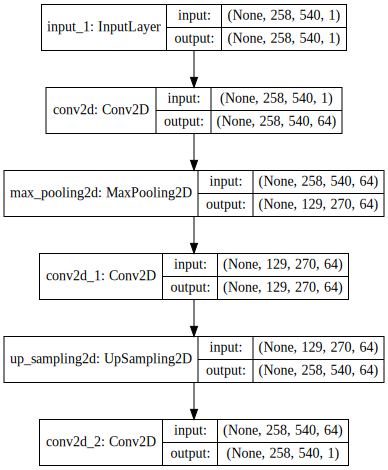

In [10]:
SVG(model_to_dot(ae.autoencoder_model, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

Train on 115 samples, validate on 29 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
115/115 [==============================] - 4s 33ms/sample - loss: 0.1624 - val_loss: 0.0791
Epoch 2/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0732 - val_loss: 0.0755
Epoch 3/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0765 - val_loss: 0.0776
Epoch 4/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0758 - val_loss: 0.0724
Epoch 5/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0681 - val_loss: 0.0673
Epoch 6/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0640 - val_loss: 0.0610
Epoch 7/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0584 - val_loss: 0.0549
Epoch 8/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.0516 - val_loss: 0.0466
Epoch 9/200
115/115 [==============================] - 1s 7ms/sample - loss: 0.043

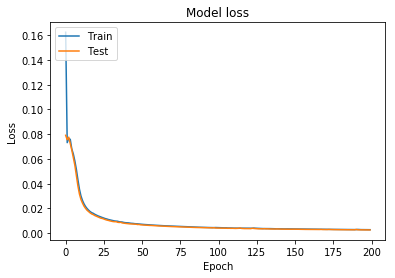

In [11]:
ae.train_model(x_train, y_train, x_val, y_val, epochs=200, batch_size=20)

In [12]:
preds = ae.eval_model(x_test)

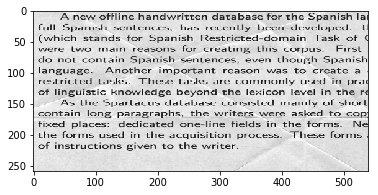

In [13]:
preds_0 = preds[10] * 255.0
preds_0 = preds_0.reshape(258, 540)
x_test_0 = x_test[10] * 255.0
x_test_0 = x_test_0.reshape(258, 540)
plt.imshow(x_test_0, cmap='gray')

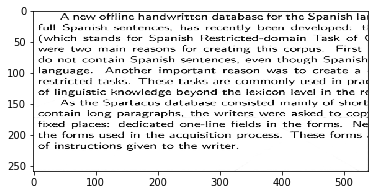

In [14]:
plt.imshow(preds_0, cmap='gray')

In [15]:
ae.autoencoder_model.save('./autoencoder.h5')